<a href="https://colab.research.google.com/github/musicjae/Algorithms/blob/master/assignment2/FullyConnectedNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment2/cs231n/datasets
/content


# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python 
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch/Layer Normalization as a tool to more efficiently optimize deep networks.
  

  두 개의 층을 가진 신경망 수행은 단순하지만 매우 모듈적이지 못했다. 왜냐하면 그 손실과 그래디언트가 하나의 거대한monolithic 함수에서 계산되기 때문이다. 이것은 단순한 신경망에 대해서는 적합하지만, 더 큰(복잡한) 모델에 대해서는 비실용적이다. <br><br>

&nbsp;&nbsp;이번에 우리는 더 모듈적인 접근을 사용하여 전연결 신경망을 수행해볼 것이다.  우리는 여기서 각각의 함수에 대하여, forward 함수와 bacward 함수를 사용한다.<br><br>

&nbsp;&nbsp; 위 방식으로 다량의 층을 계산하면, 우리는 이들을 쉽게 다양한 아키텍처를 가진 분류기를 만들게끔 결합할 수 있다. 임의의 depth의 전연결 신경망을 수행한 뒤에, 우리는 최적화에 대해 다양한 업데이트 규칙도 조사할 것이고, 정규화로서의 dropout과 더 효율적으로 심층 신경망을 최적화하는 도구로서의 Batch/Layer 정규화를 도입한다.

In [24]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [26]:
from builtins import range
import numpy as np



def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               
 ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = x.shape[0]
    #x = x.reshape(N, -1) 
    #위와 같이 x를 따로 reshape을 해주면, backward 함수에서 dx의 reshape이 제대로 되지 않는다.
    out = x.reshape(N, -1).dot(w)+b
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            
    ###########################################################################
    cache = (x, w, b)
    
    return out, cache

# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape) #flattening process 1
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape) # (2,4,5,6)
print('x의 shape: ', x.shape) # x(2,4,5,6)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
print('w의 shape: ',w.shape) # w(120, 3)
b = np.linspace(-0.3, 0.1, num=output_dim) # flattening process 2
print('b의 shape: ',b.shape) # b(3, )
out, _ = affine_forward(x, w, b) 
print('out의 shape: ', affine_forward(x,w,b)[0].shape) # (2,3)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

x의 shape:  (2, 4, 5, 6)
w의 shape:  (120, 3)
b의 shape:  (3,)
out의 shape:  (2, 3)
Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [27]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = np.dot(dout, w.T) #size 맞추기 (10,5) x (5, 6) = (10, 6)
    dx = dx.reshape(x.shape) # (10, 6) -> (10, 2, 3)
    
    x = x.reshape(len(x),-1) #flattening 해주기 (10, 6)
    
    dw = np.dot(x.T, dout) # (6, 10) x (10, 5) = (6, 5)
    
    db = np.sum(dout, axis=0) #(5, ) // (6,5)인 dout의 각각의 열을 모두 더해줌
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
print('dx의 shape: ',dx.shape)
print('dw의 shape: ',dw.shape)
print('db의 shape: ',db.shape) 
# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx의 shape:  (10, 2, 3)
dw의 shape:  (6, 5)
db의 shape:  (5,)
Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [28]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.maximum(0,x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))




Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [29]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout * (x>0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)
print('dout의 shape: ',dout.shape)
print('dx의 shape: ',dx.shape)
print('dx_num의 shape: ',dx_num.shape)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))


dout의 shape:  (10, 10)
dx의 shape:  (10, 10)
dx_num의 shape:  (10, 10)
Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
답 (1). 시그모이드 함수를 사용하면, $|x|$가 커질수록, 그것의 미분 값이 0에 수렴하기 때문에, vanishing gradient 현상이 나타난다. 나머지 ReLU 유형의 함수들은 이런 문제를 해결해준다.



# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:


&nbsp;&nbsp; 신경망에서 자주 사용되는 층의 흔한 패턴이 있다. 예를 들자면, 아핀affine층은 보통 ReLU 비선형성에 뒤이어 나온다. 이 흔한 패턴을 쉽게 만들어주기 위해, 우리는 `cs231n/layer_utils.py` 파일에서 몇 가지 편리 층 convenience layers을 정의한다.<br><br>
&nbsp;&nbsp;이제, `affine_relu_forward` and `affine_relu_backward` functions를 살펴보자.

In [30]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [31]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))
a = rel_error(dx_num, dx)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))
b = rel_error(dx_num, dx)

print('>>\n For loss, svm > softmax, but for dx_error, svm < softmax')

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09
>>
 For loss, svm > softmax, but for dx_error, svm < softmax


In [32]:
a = np.array([1,2,3,4,5,6])
a = a.reshape(2,3)

b=np.array([1,1,1])
b = b.reshape(3, )

print('a 행렬: ','\n','\n', a,'\n','\n','bias: ','\n','\n', b,'\n','\n','브로드 캐스팅 결과: ','\n','\n',a+b)

a 행렬:  
 
 [[1 2 3]
 [4 5 6]] 
 
 bias:  
 
 [1 1 1] 
 
 브로드 캐스팅 결과:  
 
 [[2 3 4]
 [5 6 7]]


In [33]:
from builtins import range
import numpy as np


from cs231n.layers import *
from cs231n.fast_layers import *

class test(object):

    def __init__(self, affine_relu_forward):
        self.affine_relu_forward = affine_relu_forward
    

    def affine_forward(x, w, b):
        out = None
        ###########################################################################
        N = x.shape[0]
        out = x.reshape(N, -1).dot(w)+b
        ###########################################################################
        cache = (x, w, b)

        return out, cache

    def affine_backward(dout, cache):
   
        x, w, b = cache
        dx, dw, db = None, None, None
        ###########################################################################
   
        dx = np.dot(dout, w.T) #size 맞추기 (10,5) x (5, 6) = (10, 6)
        dx = dx.reshape(x.shape) # (10, 6) -> (10, 2, 3)
    
        x = x.reshape(len(x),-1) #flattening 해주기 (10, 6)
    
        dw = np.dot(x.T, dout) # (6, 10) x (10, 5) = (6, 5)
    
        db = np.sum(dout, axis=0) #(5, ) // (6,5)인 dout의 각각의 열을 모두 더해줌
     
        ###########################################################################
        return dx, dw, db



    def affine_relu_forward(x, w, b):
   
        a, fc_cache = affine_forward(x, w, b)
        out, relu_cache = relu_forward(a)
        cache = (fc_cache, relu_cache)

        return out, cache

    def affine_relu_backward(dout, cache):
    
        fc_cache, relu_cache = cache
        da = relu_backward(dout, relu_cache)
        dx, dw, db = affine_backward(da, fc_cache)
    
        return dx, dw, db

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape) #flattening process 1
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape) # (2,4,5,6)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim) # flattening process 2

print('x의 shape: ', x.shape) # x(2,4,5,6)
print('w의 shape: ',w.shape) # w(120, 3)
print('b의 shape: ',b.shape) # b(3, )

model = test(affine_relu_forward)

aa = model.affine_relu_forward(x,w,b)
#a = model.affine_relu_backward(aa[0],aa[1])

list_aa = list(aa)

print(list_aa[0].shape)
print(list_aa[1][1])


x의 shape:  (2, 4, 5, 6)
w의 shape:  (120, 3)
b의 shape:  (3,)
(2, 3)
[[1.49834967 1.70660132 1.91485297]
 [3.25553199 3.5141327  3.77273342]]


In [34]:
#My small lab test (not contained in assignment2)

class TwoLayerNet(object):
   

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        self.params = {}
        self.reg = reg

        self.params['W1'] = weight_scale*np.random.randn(input_dim,hidden_dim)
        self.params['b1'] = np.zeros(hidden_dim)

        self.params['W2'] = weight_scale*np.random.randn(hidden_dim, num_classes)
        self.params['b2'] = np.zeros(num_classes)


    def loss(self, X, y=None):
        
        scores = None
        # X = 3, 5
        W1 = self.params['W1'] # 5, 50
        W2 = self.params['W2'] # 50, 7
        b1 = self.params['b1'] # 50,
        b2 = self.params['b2'] # 7,
     
############################# start ##########################################
       
        h, cache1 = affine_relu_forward(X, W1, b1)
        scores, cache2 = affine_forward(h, W2, b2)  

############################## end #############################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores # 3,7

            loss, grads = 0, {}
        ########################################################################
        # (1) grad 딕셔너리에 그래디언트를, 손실 변수에는 손실을 저장하라. 
        # (2) 소프트맥스를 사용하여 데이터 손실을 계산하라
        # (3) grad[k]가 self.param[k]의 grad에 성립한다는 것을 확인하라.
        # (4) 정규화 L2 하라
        # (5) 0.5 인자를 포함하여 그래디언트 표현을 단순화 하라.                                                            
        ########################################################################

        loss, dout = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(W1**2)+(np.sum(W2**2)))
        dout = softmax_loss(scores, y)[1]
        dh, dW2, db2 = affine_relu_backward(dout, cache2)
        dx, dW1, db1 = affine_relu_backward(dh, cache1)
        
        grads['W2'] = dW2 + self.reg * W2
        grads['b2'] = db2

        grads['W1'] = dW + self.reg * W1
        grads['b1'] = db1

        return loss, grads
        ########################################################################
      
    N, D, H, C = 3, 5, 50, 7
    X = np.random.randn(N, D)
    dout= None
    cache2 = []
    std = 1e-3

    model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

    print('W1: ',model.params['W1'].shape)
    print('W2: ',model.params['W2'].shape)
    print('b1: ',model.params['b1'].shape)
    print('b2: ',model.params['b2'].shape)
    print('X * W1 = ', np.dot(X, model.params['W1']).shape)
    print('scores = ', scores.shape)
    print('손실: ', softmax_loss(scores, y)[0])
    print('dout: ' , softmax_loss(scores, y)[1].shape)
    print('dW2: ', affine_relu_backward(dout, cache2))
    print('grad dW2: ', grad['W2'])
    
    

W1:  (5, 50)
W2:  (50, 7)
b1:  (50,)
b2:  (7,)
X * W1 =  (3, 50)


NameError: ignored

# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

&nbsp;&nbsp; 이전 과제에서 우리는 하나의 획일적인monolithic 클래스 내에서 복층two-layer신경망을 실행해봤다. 우리는 이미 necessary layers의 모듈 버젼을 실행해봤기 때문에,  이 모듈을 사용하여 아래에서 복층 신경망을 다시 실행해볼 것이다.<br><br>`cs231n/classifiers/fc_net.py`를 열어서 TwoLayerNet class를 완성해 보자. 이 클래스는 우리가 이 과제 내에서 수행할 다른 신경망에 대한 모델을 제공할 것이다. 따라서 이 API를 확실히 이해하기 위해 이 클래스를 자세히 읽어보라. 


In [ ]:
class TwoLayerNet(object):
    """
 
      ReLU 비선형 함수와 모듈적 층 디자인을 사용하는 소프트맥스 손실을 가진 복층 전연결 신경망. 우리는
    입력값 차원을 D, 은닉 차원을 H 개라고 하고, C 개의 클래스로 분류를 수행한다.

    아키텍처는 affine -- 렐루 -- affine -- 소프트맥스로 구성된다.

    이 클래스가 경사 하강법을 수행하지 않는 대신에 <최적화를 수행하는 별개의 solver 대상>과 상호작용
    한다는 것에 주목하자.

    이 모델의 학습 가능한 매개변수는 <모수 이름>에서 <배열>로 사상하는 self.params 딕셔너리에 저장된다
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params['W1'] = weight_scale*np.random.randn(input_dim,hidden_dim)
        self.params['W2'] = weight_scale*np.random.randn(hidden_dim, num_classes)
        self.params['b1'] = np.zeros(hidden_dim,) 
        self.params['b2'] = np.zeros(num_classes,)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        layer1_output, layer1_cache = affine_relu_forward(X, self.params["W1"], self.params["b1"])
        scores, layer2_cache = affine_forward(layer1_output, self.params["W2"], self.params["b2"])
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dscores = softmax_loss(scores, y)
        dlayer1, grads["W2"], grads["b2"] = affine_backward(dscores, layer2_cache)
        dx, grads["W1"], grads["b1"] = affine_relu_backward(dlayer1, layer1_cache)

        loss += 0.5 * self.reg * np.sum(self.params["W1"] * self.params["W1"]) + 0.5 * self.reg * np.sum(self.params["W2"] *  self.params["W2"])
        grads["W1"] += self.reg * self.params["W1"]
        grads["W2"] += self.reg * self.params["W2"]
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

      ###########################  main  #########################################


np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [ ]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, data,
                update_rule='sgd',
                optim_config={'learning_rate': 1e-3},
                lr_decay=0.95,
                num_epochs=10, batch_size=100,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# 두 그래프 간의 간격이 너무 크다 ==> overfitting ==> reg 높여줘야 함.
# 반대로 너무 좁다 ==> 모델 capacity 를 증가시켜 줘야 해


# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

In [ ]:
# Studying of the fc_net in my small lab

from builtins import range
from builtins import object
import numpy as np

from cs231n.layers import *
from cs231n.layer_utils import *


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
        use_batchnorm=False
    ):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.

        - dropout: giving dropout strength, 0~1의 스칼라. If dropout=1 then dropout 사용 x.

        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: 가중치의 랜덤 초기화의 표준 편차를 제공해주는 스칼라
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.

        - seed:
        
         If seed = None, then this random seed ==pass==> dropout layers.
        
         This will make the dropout layers deteriminstic, so we can gradient check the
          model.
        """


        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.        
        ############################################################################
        """ 
        모든 값을 self.params 딕셔너리에 저장하면서, 연결망의 모수를 초기화하라. 가중치는 표준 정구 분포로
        초기화되어야 하고, bias는 0으로 초기화되어야 한다.

        배치 정규화 사용 시, 스케일, 쉬프트 모수를 감마, 베타에 저장하라. 스케일 모수는 1로 쉬프트 모수는 0으로
        초기화 하라.

        """

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dims = np.hstack((input_dim, hidden_dims, num_classes))

        for i in range(self.num_layers):
            self.params['W%d' % (i + 1)] = weight_scale * np.random.randn(dims[i], dims[i+1])
            self.params['b%d' % (i + 1)] = np.zeros(dims[i+1])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        """
        드롭아웃 사용 시, 우리는 layer가 드롭아웃_확률과 그 mode(학습/테스트)를 알게 하기 위해
        <드롭아웃_모수 딕셔너리>를 --> <각 드롭아웃 레이어>로 보낼 필요가 있다.
        """
        self.dropout_param = {} # dropout 모수 초기화.
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.

        """
        배치 정규화를 가지고서, 우리는 평균, 분산을 추적할 필요가 있고, 따라서 특별한 bn_param 객체를
        각 배치 정규화 layer로 보낼 필요가 있다. 당싲은 self.bn_params[0]를 1st 배치 정규화 층의
        순전파로 보낼 필요가 있고, self.bn_params[1]를 2nd 배치 정규화의 순전파로 보낼 필요가 있다.
        """

        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        hidden_num = self.num_layers - 1
        scores = X
        cache_history = []
        L2reg = 0
        for i in range(hidden_num):
            if self.use_batchnorm:
                scores, cache = affine_bn_relu_forward(scores,
                                                      self.params['W%d' % (i + 1)],
                                                      self.params['b%d' % (i + 1)],
                                                      self.params['gamma%d' % (i + 1)],
                                                      self.params['beta%d' % (i + 1)],
                                                      self.bn_params[i])
            else:
                scores, cache = affine_relu_forward(scores, self.params['W%d' % (i + 1)],
                                                            self.params['b%d' % (i + 1)])
            cache_history.append(cache)
            if self.use_dropout:
                scores, cache = dropout_forward(scores, self.dropout_param)
                cache_history.append(cache)
            L2reg += np.sum(self.params['W%d' % (i + 1)] ** 2)
        i += 1
        scores, cache = affine_forward(scores, self.params['W%d' % (i + 1)],
                                               self.params['b%d' % (i + 1)])
        cache_history.append(cache)
        L2reg += np.sum(self.params['W%d' % (i + 1)] ** 2)
        L2reg *= 0.5 * self.reg

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dout = softmax_loss(scores, y)
        loss += L2reg

        dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)] = affine_backward(dout, cache_history.pop())
        grads['W%d' % (i + 1)] += self.reg * self.params['W%d' % (i + 1)]
        i -= 1
        while i >= 0:
            if self.use_dropout:
                dout = dropout_backward(dout, cache_history.pop())
            if self.use_batchnorm:
                dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)], grads['gamma%d' % (i + 1)], grads['beta%d' % (i + 1)] = affine_bn_relu_backward(dout, cache_history.pop())
            else:
                dout, grads['W%d' % (i + 1)], grads['b%d' % (i + 1)] = affine_relu_backward(dout, cache_history.pop())
            grads['W%d' % (i + 1)] += self.reg * self.params['W%d' % (i + 1)]
            i -= 1

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [35]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.86e-09
W2 relative error: 3.52e-08
W3 relative error: 1.32e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.020000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.020000; val_acc: 0.106000
(Epoch 2 / 20) train acc: 0.020000; val_acc: 0.110000
(Epoch 3 / 20) train acc: 0.020000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.040000; val_acc: 0.109000
(Epoch 5 / 20) train acc: 0.040000; val_acc: 0.111000
(Iteration 11 / 40) loss: 2.270022
(Epoch 6 / 20) train acc: 0.040000; val_acc: 0.111000
(Epoch 7 / 20) train acc: 0.060000; val_acc: 0.112000
(Epoch 8 / 20) train acc: 0.060000; val_acc: 0.111000
(Epoch 9 / 20) train acc: 0.040000; val_acc: 0.110000
(Epoch 10 / 20) train acc: 0.040000; val_acc: 0.109000
(Iteration 21 / 40) loss: 2.309562
(Epoch 11 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 12 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 13 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 14 / 20) train acc: 0.060000; val_acc: 0.110000
(Epoch 15 / 20) train acc: 0.060000; val_acc: 0.113000
(Iteration 31 / 40) loss: 

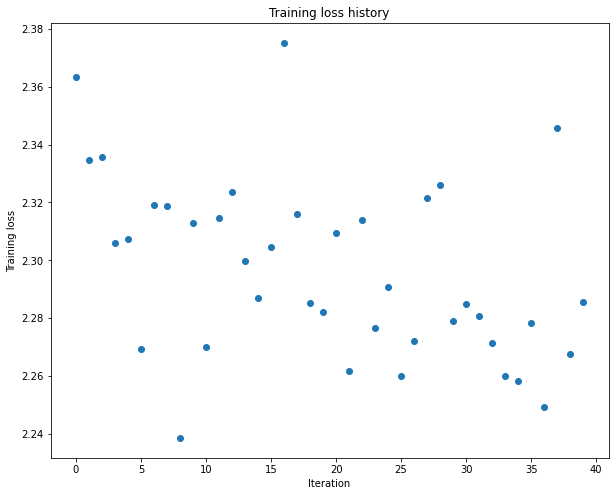

In [36]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.302585
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 2.301962
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 2.301859
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 31 / 40) loss: 

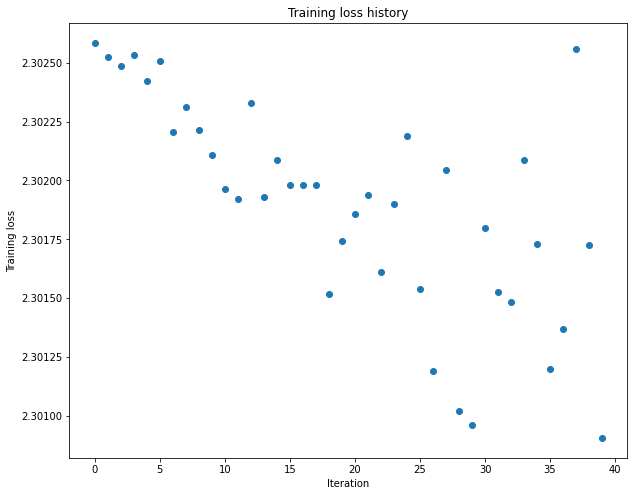

In [37]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1e-5   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [43]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.356069
(Iteration 21 / 200) loss: 2.214091
(Iteration 31 / 200) loss: 2.205928
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 41 / 200) loss: 2.132095
(Iteration 51 / 200) loss: 2.118950
(Iteration 61 / 200) loss: 2.116443
(Iteration 71 / 200) loss: 2.132549
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 81 / 200) loss: 1.977227
(Iteration 91 / 200) loss: 2.007528
(Iteration 101 / 200) loss: 2.004762
(Iteration 111 / 200) loss: 1.885342
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.891517
(Iteration 131 / 200) loss: 1.923677
(Iteration 141 / 200) loss: 1.957743
(Iteration 151 / 200) loss: 1.966736
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 161 / 200) loss: 1.801483
(Iteration 171 / 200) loss: 1.973779
(Iteration 181 / 200) loss: 1.666572
(Iteration 191 / 200) los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

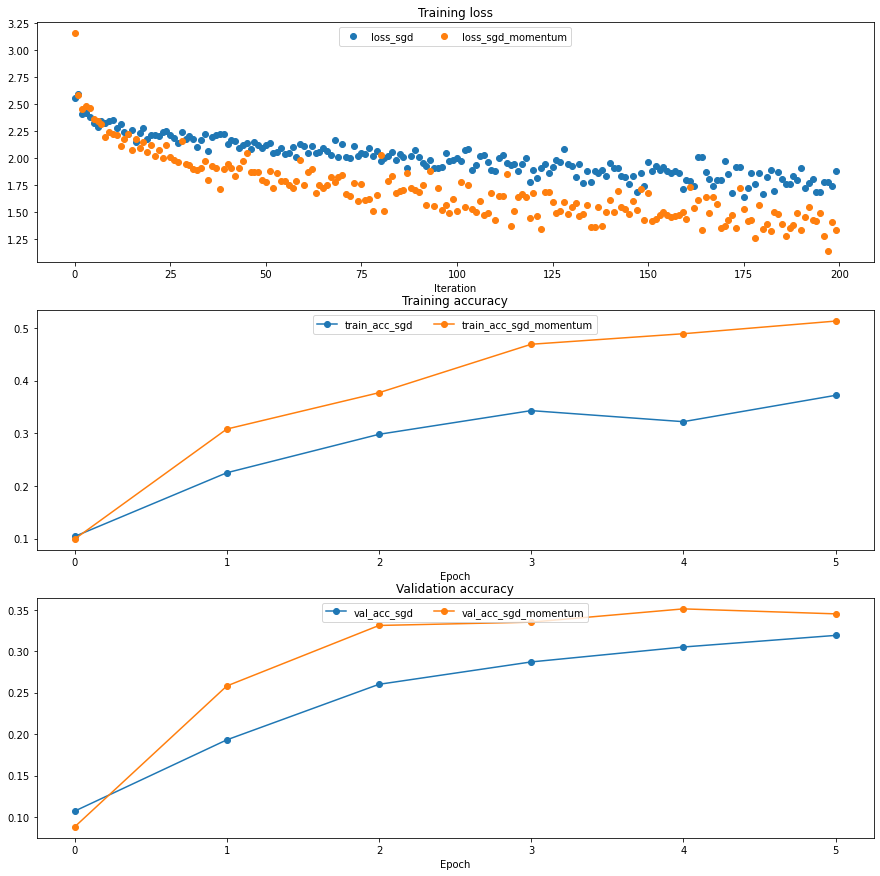

In [44]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [45]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [46]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.143000; val_acc: 0.114000
(Iteration 11 / 200) loss: 2.089203
(Iteration 21 / 200) loss: 2.211850
(Iteration 31 / 200) loss: 1.786014
(Epoch 1 / 5) train acc: 0.393000; val_acc: 0.340000
(Iteration 41 / 200) loss: 1.743813
(Iteration 51 / 200) loss: 1.752165
(Iteration 61 / 200) loss: 2.095686
(Iteration 71 / 200) loss: 1.489003
(Epoch 2 / 5) train acc: 0.411000; val_acc: 0.357000
(Iteration 81 / 200) loss: 1.546641
(Iteration 91 / 200) loss: 1.412223
(Iteration 101 / 200) loss: 1.401821
(Iteration 111 / 200) loss: 1.521807
(Epoch 3 / 5) train acc: 0.494000; val_acc: 0.368000
(Iteration 121 / 200) loss: 1.237183
(Iteration 131 / 200) loss: 1.466022
(Iteration 141 / 200) loss: 1.284994
(Iteration 151 / 200) loss: 1.466689
(Epoch 4 / 5) train acc: 0.529000; val_acc: 0.383000
(Iteration 161 / 200) loss: 1.405442
(Iteration 171 / 200) loss: 1.270961
(Iteration 181 / 200) loss: 1.271557
(Iteration 191 / 200) lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

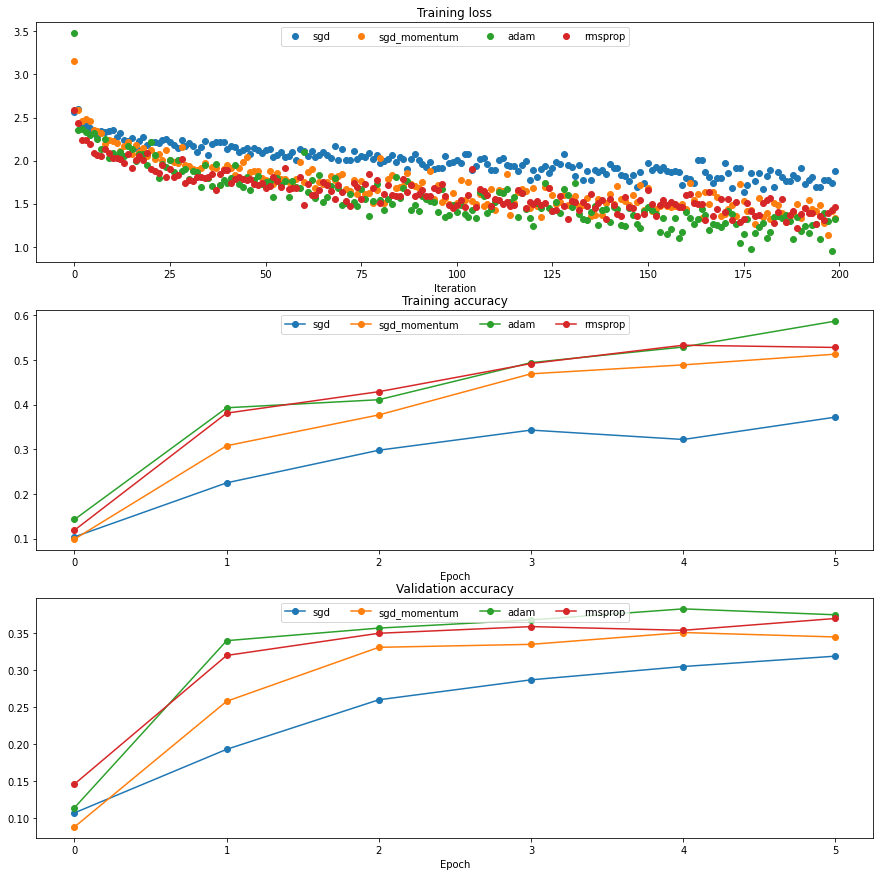

In [47]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
[FILL THIS IN]


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())